In [1]:
import pandas as pd

file_path = "./dataset/customer_shopping_data.csv"
data = pd.read_csv(file_path)

data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [22]:
data["invoice_date"] = pd.to_datetime(data["invoice_date"], format="%d/%m/%Y")
instanbul_data = data[data["shopping_mall"] == "Mall of Istanbul"]
instanbul_data

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
7,I293112,C176086,Female,32,Clothing,2,600.16,Credit Card,2021-01-13,Mall of Istanbul
26,I196704,C289625,Female,25,Cosmetics,5,203.30,Credit Card,2022-04-20,Mall of Istanbul
30,I161949,C159164,Female,66,Toys,3,107.52,Debit Card,2022-07-04,Mall of Istanbul
46,I267193,C317818,Female,19,Cosmetics,3,121.98,Credit Card,2023-01-12,Mall of Istanbul
60,I133061,C336576,Male,64,Clothing,5,1500.40,Credit Card,2022-06-09,Mall of Istanbul
...,...,...,...,...,...,...,...,...,...,...
99431,I191779,C131280,Male,26,Cosmetics,4,162.64,Credit Card,2021-12-28,Mall of Istanbul
99432,I133264,C289915,Female,41,Books,2,30.30,Debit Card,2022-02-23,Mall of Istanbul
99443,I152790,C223470,Male,41,Cosmetics,4,162.64,Debit Card,2021-07-26,Mall of Istanbul
99444,I131678,C119287,Male,24,Toys,1,35.84,Cash,2021-11-26,Mall of Istanbul


In [67]:
#使用 ARIMA 模型進行 Mall of Istanbul 價格分析
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

instanbul_data["revenue"] = instanbul_data["quantity"] * instanbul_data["price"]
instanbul_data["date"] = instanbul_data["invoice_date"].dt.to_period("d")
daily_revenue = instanbul_data.groupby("date")["revenue"].sum()

#Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test\n================================================")
adf_result  = adfuller(daily_revenue)

# 輸出ADF測試結果
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# 根據結果判斷時間序列的穩定性
if adf_result[0] < adf_result[4]["5%"]:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

Results of Dickey-Fuller Test
ADF Statistic: -26.044686
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
The time series is stationary.


C:\Users\Samuel\AppData\Local\Temp\ipykernel_18384\1200626135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instanbul_data["revenue"] = instanbul_data["quantity"] * instanbul_data["price"]
C:\Users\Samuel\AppData\Local\Temp\ipykernel_18384\1200626135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instanbul_data["date"] = instanbul_data["invoice_date"].dt.to_period("d")


<Figure size 1200x600 with 0 Axes>

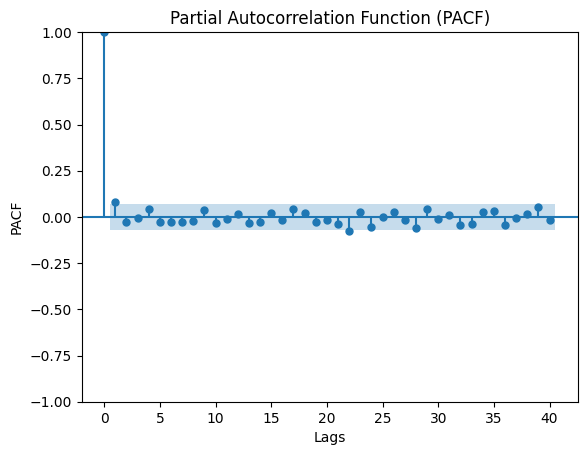

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 繪製PACF圖
plt.figure(figsize=(12, 6))
plot_pacf(daily_revenue, lags=40, method='ywm')  # 指定延遲數和估計方法
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

AR(0) model AIC: 18427.56917621778
AR(1) model AIC: 18429.853991312382
AR(2) model AIC: 18423.972932046156
AR(3) model AIC: 18425.04999050883
AR(4) model AIC: 18427.03954663827


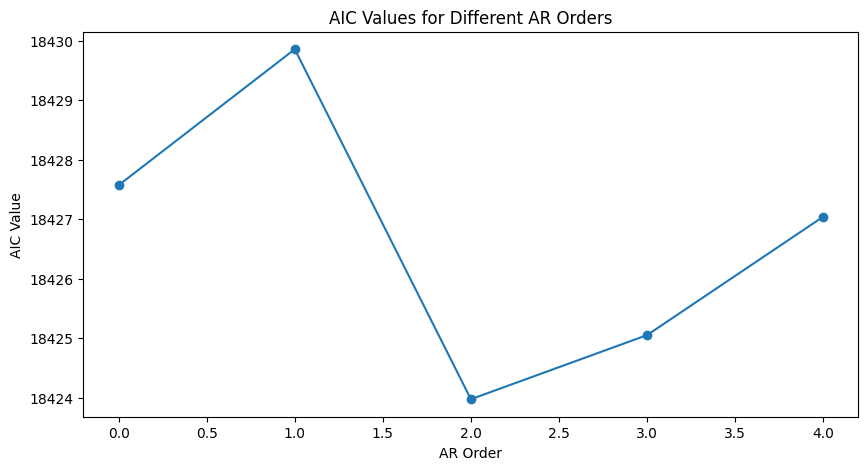

In [69]:
# 評估不同AR階數的AIC值
aic_values = []
ar_orders = range(0, 5)  # 假設我們測試從0到4的AR階數
for p in ar_orders:
    model = ARIMA(daily_revenue, order=(p, 0, 2))  # d設為0，因為數據平穩不需差分
    results = model.fit()
    aic_values.append(results.aic)
    print(f'AR({p}) model AIC: {results.aic}')

# 繪製AIC值以視覺化比較
plt.figure(figsize=(10, 5))
plt.plot(ar_orders, aic_values, marker='o')
plt.xlabel('AR Order')
plt.ylabel('AIC Value')
plt.title('AIC Values for Different AR Orders')
plt.show()

AR(0) model AIC: 18427.303881919885
AR(1) model AIC: 18429.2924207246
AR(2) model AIC: 18423.972932046156
AR(3) model AIC: 18425.017658808436
AR(4) model AIC: 18426.981918163612
AR(5) model AIC: 18433.82777891556


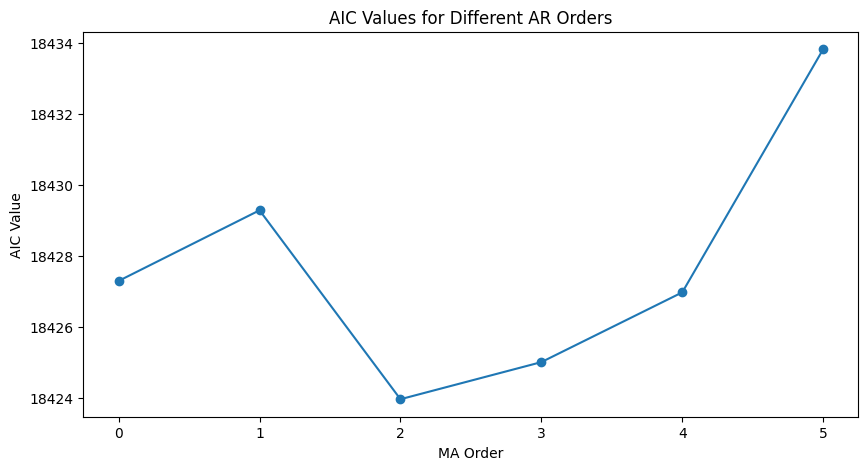

In [70]:
# 根據剛剛測試，我們將 p 設為 1
aic_values = []
ar_orders = range(0, 6)  # 假設我們測試從0到4的AR階數
for q in ar_orders:
    model = ARIMA(daily_revenue, order=(2, 0, q))  # d設為0，因為假設數據已平穩
    results = model.fit()
    aic_values.append(results.aic)
    print(f'AR({q}) model AIC: {results.aic}')

# 繪製MA值以視覺化比較
plt.figure(figsize=(10, 5))
plt.plot(ar_orders, aic_values, marker='o')
plt.xlabel('MA Order')
plt.ylabel('AIC Value')
plt.title('AIC Values for Different AR Orders')
plt.show()

#回頭做AR 直到找到最適參數

In [71]:
model = ARIMA(daily_revenue, order=(2, 0, 2))
model_fit = model.fit()

# 預測
forecast = model_fit.forecast(steps=23)  # 預測未來23天的收入
forecast

2023-03-09    64123.415666
2023-03-10    61152.786174
2023-03-11    66723.664726
2023-03-12    62776.985665
2023-03-13    62525.618501
2023-03-14    66291.205283
2023-03-15    62079.188475
2023-03-16    63727.284483
2023-03-17    65490.013498
2023-03-18    61965.956544
2023-03-19    64564.942168
2023-03-20    64603.434878
2023-03-21    62273.258231
2023-03-22    64982.597115
2023-03-23    63841.594469
2023-03-24    62802.952464
2023-03-25    65028.780632
2023-03-26    63321.552151
2023-03-27    63374.565954
2023-03-28    64813.041712
2023-03-29    63073.002910
2023-03-30    63856.832101
2023-03-31    64463.806840
Freq: D, Name: predicted_mean, dtype: float64

C:\Users\Samuel\AppData\Local\Temp\ipykernel_18384\153930997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instanbul_data["year_month"] = instanbul_data["invoice_date"].dt.to_period("M")


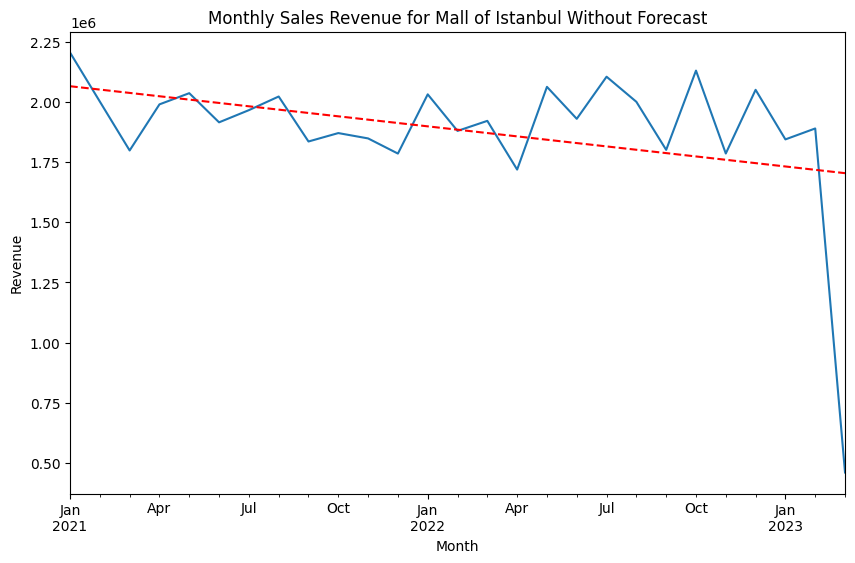

============補上預測前的趨勢圖===========


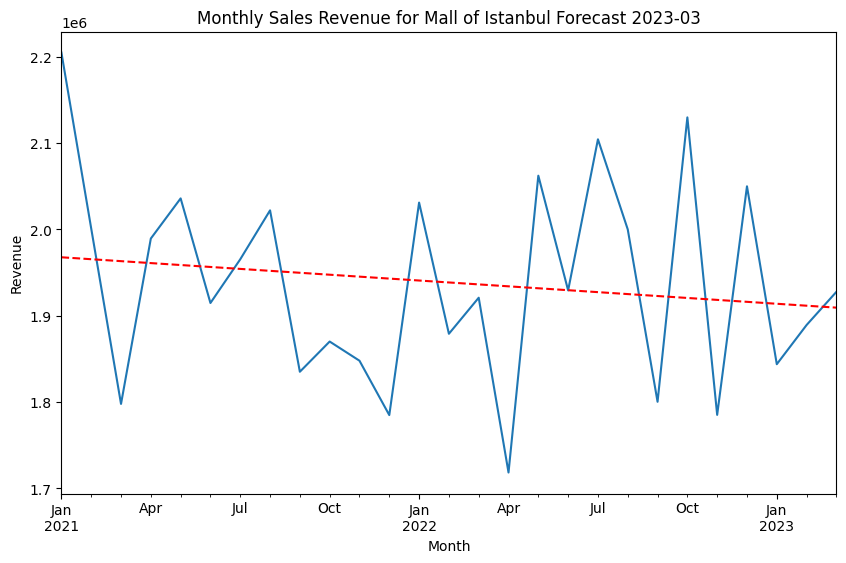

In [77]:
#回頭繪製趨勢圖
import numpy as np

instanbul_data["year_month"] = instanbul_data["invoice_date"].dt.to_period("M")
monthly_revenue = instanbul_data.groupby("year_month")["revenue"].sum()

#Adding a trendline
trendline = np.polyfit(range(len(monthly_revenue)), monthly_revenue, 1)
p = np.poly1d(trendline)


plt.figure(figsize=(10, 6))
monthly_revenue.plot(kind="line")
#draw trendline
plt.plot(monthly_revenue.index.to_numpy(), p(range(len(monthly_revenue))), linestyle = "--", color="red", label="Trendline")
plt.title("Monthly Sales Revenue for Mall of Istanbul Without Forecast")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


#將 3 月份後續的日子用預測方式補上
monthly_revenue["2023-03"] = monthly_revenue["2023-03"] + forecast.sum()
#Adding a trendline
trendline = np.polyfit(range(len(monthly_revenue)), monthly_revenue, 1)
p = np.poly1d(trendline)

plt.figure(figsize=(10, 6))
monthly_revenue.plot(kind="line")
#draw trendline
plt.plot(monthly_revenue.index.to_numpy(), p(range(len(monthly_revenue))), linestyle = "--", color="red", label="Trendline")
plt.title("Monthly Sales Revenue for Mall of Istanbul Forecast 2023-03")
plt.xlabel("Month")
plt.ylabel("Revenue")

print("============補上預測前的趨勢圖===========")
plt.show()